# COGS 108 - EDA Checkpoint

# Names

- Victoria Thai
- Hannah Yick
- Jane Dinh
- Natasha Supangkat
- Gabriel Ramiro

<a id='research_question'></a>
# Research Question

What trends can be found between a county’s designation of a superfund site and its socioeconomic/demographic trends? Does the demographic makeup of a county influence the amount of time between Superfund designation and the completion of the remediation process?

# Setup

In [1]:
#Imports 
import pandas as pd
import numpy as np

#Graphing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#Webscraping
import requests 
import bs4
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# Read in the data and store it within a data frame
#npl_df = npl_df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group011_sp21/main/All%20current%20Final%20NPL%20Sites%20(FOIA%204).csv?token=AI2VKGQIIMQPBWGAZGPKD5DASR4CO') 
gdrive_npl_id = '1oDIJ_v9s5i5THULln_C-N4o3Aiz0e7mu'
npl_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_npl_id}&export=download', encoding='ISO-8859-1')
gdrive_acs_id = '1kNWY1Kc4RhQ9ttK7dTYtj0fhHE3BXOGh'
acs_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_acs_id}&export=download', encoding='ISO-8859-1')

pd.options.display.max_rows = 5
pd.options.display.max_columns = 8

# Data Cleaning

Data cleaning from Checkpoint 1.

In [2]:
npl_df = npl_df.drop(["Region", "Site ID", "EPA ID", "Address", "Zip", "FF Ind", "Latitude", "Longitude"], axis=1)

In [3]:
acs_df = acs_df.drop([0], axis=0)
acs_df.reset_index(drop=True, inplace=True)

acs_df.dropna(axis = 0, how = 'all', inplace = True)
acs_df.dropna(axis = 1, how = 'all', inplace = True)

acs_df.drop(labels=['FIPS', 'Geographic Identifier', 'Summary Level', 'Geographic Component', 
                    'File identification', 'Logical Record Number', 'State (FIPS Code)', 
                    'County of current residence', 'Total Population.1', 'Population Density (Per Sq. Mile)', 
                    'Area (Land)', 'Total Population:', 'Total Population: White Alone', 
                    'Total Population: Black or African American Alone', 
                    'Total Population: American Indian and Alaska Native Alone', 'Total Population: Asian Alone', 
                    'Total Population: Native Hawaiian and Other Pacific Islander Alone', 
                    'Total Population: Some Other Race Alone', 'Total Population: Two or More Races'], axis=1, inplace = True)
acs_df.drop(index=acs_df[acs_df['State Postal Abbreviation'] == 'pr'].index, inplace=True)
acs_df.drop(list(acs_df.filter(regex = 'At or Above Poverty Level')), axis = 1, inplace = True)

acs_df = acs_df.iloc[:, np.r_[0:11, 12:23, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67]]

We'll need to adjust our dataset now that we have a better understanding of our data and how we want to work with it. Here, we'll work towards merging our two datasets. Let's start by standardizing the datasets - first, let's take a look at our NPL dataset.

In [4]:
npl_df.head()

,State,Site Name,City,County,NPL Status Date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,MIDDLESEX,10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,WINDHAM,10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,FAIRFIELD,9/21/1984


We'll convert the column names into lowercase, and continue this use of lowercase column names as we progress with both datasets as a standardization measure.

In [5]:
npl_df.columns = ['state', 'site name', 'city', 'county', 'npl status date']
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,MIDDLESEX,10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,WINDHAM,10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,FAIRFIELD,9/21/1984


Let's examine the dataset and check for missingness.

In [6]:
npl_df.isna().sum().sum()

20

In [7]:
npl_df.isna().any()

state              False
site name          False
city               False
county              True
npl status date    False
dtype: bool

From this, we can see that all the missing data is in the County variable.

In [8]:
#subset to just rows with missing data
npl_df[npl_df.isnull().any(axis=1)]

,state,site name,city,county,npl status date
266,NY,NEWTOWN CREEK,"BROOKLYN, QUEENS",NaN,9/29/2010
303,PR,FIBERS PUBLIC SUPPLY WELLS,JOBOS,NaN,9/21/1984
...,...,...,...,...,...
1263,ID,EASTERN MICHAUD FLATS CONTAMINATION,POCATELLO,NaN,8/30/1990
1264,ID,IDAHO NATIONAL ENGINEERING LABORATORY (USDOE),IDAHO FALLS,NaN,11/21/1989


In addition, we added a Duration column that will come into play as we plot our data.

In [9]:
npl_df['duration'] = npl_df['npl status date'].str[-4:]
npl_df = npl_df.astype({"duration": int})
npl_df['duration'] = 2021 - npl_df['duration']
npl_df

,state,site name,city,county,npl status date,duration
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989,32
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983,38
...,...,...,...,...,...,...
1325,WA,"WESTERN PROCESSING CO., INC.",KENT,KING,9/8/1983,38
1326,WA,WYCKOFF CO./EAGLE HARBOR,BAINBRIDGE ISLAND,KITSAP,7/22/1987,34


Next, let's take a look at our ACS dataset.

In [10]:
acs_df.head()

,Area Name,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,Autauga County,"Autauga County, Alabama",al,55380,...,26.19,16.97,4.37,11.12
1,Baldwin County,"Baldwin County, Alabama",al,212830,...,26.28,10.79,18.41,8.4
2,Barbour County,"Barbour County, Alabama",al,25361,...,50.34,55.85,61.25,14.71
3,Bibb County,"Bibb County, Alabama",al,22493,...,NaN,0,0,16.34
4,Blount County,"Blount County, Alabama",al,57681,...,2.64,19.1,25.46,12.33


We'll need to standardize the formatting for the column describing the county of each observation to match that of our NPL datset, which contains just the county name, all uppercase, with no added "COUNTY" after the name. We can achieve this using the .upper(), .replace(), and .strip() methods.

In [11]:
acs_df.rename({'Area Name': 'county'}, axis=1, inplace=True)
acs_df['county'] = acs_df['county'].str.upper()
acs_df['county'] = acs_df['county'].str.replace('COUNTY', '')
acs_df['county'] = acs_df['county'].str.strip()
acs_df.head()

,county,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,AUTAUGA,"Autauga County, Alabama",al,55380,...,26.19,16.97,4.37,11.12
1,BALDWIN,"Baldwin County, Alabama",al,212830,...,26.28,10.79,18.41,8.4
2,BARBOUR,"Barbour County, Alabama",al,25361,...,50.34,55.85,61.25,14.71
3,BIBB,"Bibb County, Alabama",al,22493,...,NaN,0,0,16.34
4,BLOUNT,"Blount County, Alabama",al,57681,...,2.64,19.1,25.46,12.33


Now that we have a common column, we can merge our datasets. We'll use a left merge with our NPL dataset as our left-dataset, since we only need the demographic data for the county of the NPL sites.

In [12]:
county_df = pd.merge(npl_df, acs_df, on='county', how='left')
county_df

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,...,15.94,13.52,18.48,5.65
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,...,24.18,18.23,22.18,6.9
...,...,...,...,...,...,...,...,...,...
5739,WA,"WESTERN PROCESSING CO., INC.",KENT,KING,...,16.16,10.74,14.38,6.27
5740,WA,WYCKOFF CO./EAGLE HARBOR,BAINBRIDGE ISLAND,KITSAP,...,17.52,12.07,10.36,7.89


In [13]:
county_df[county_df['county'] == 'ADAMS']

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
1294,PA,HUNTERSTOWN ROAD,STRABAN TOWNSHIP,ADAMS,...,13.1,13.15,15.15,6.69
1295,PA,HUNTERSTOWN ROAD,STRABAN TOWNSHIP,ADAMS,...,0,25,0,12.39
...,...,...,...,...,...,...,...,...,...
5233,CO,ROCKY MOUNTAIN ARSENAL (USARMY),ADAMS COUNTY,ADAMS,...,33.8,33.25,32.68,12.26
5234,CO,ROCKY MOUNTAIN ARSENAL (USARMY),ADAMS COUNTY,ADAMS,...,0,32.27,15.65,12.34


In [14]:
county_df.loc[county_df['county'] != np.NaN, 'county'] = county_df.county.map(str) + ", " + county_df.state

In [15]:
county_df.sample(n=5)

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
5595,WA,CENTRALIA MUNICIPAL LANDFILL,CENTRALIA,"LEWIS, WA",...,0,30.39,12.94,13.91
3585,MN,BAYTOWN TOWNSHIP GROUND WATER PLUME,BAYTOWN TOWNSHIP,"WASHINGTON, MN",...,21.76,16.49,19.43,10
5159,CO,BRODERICK WOOD PRODUCTS,DENVER,"ADAMS, CO",...,0,25,0,12.39
2608,SC,TOWNSEND SAW CHAIN CO.,PONTIAC,"RICHLAND, SC",...,0,0,11.35,5.76
5141,CO,AIR FORCE PLANT PJKS,LITTLETON,"JEFFERSON, CO",...,37.85,13.02,14.42,9.37


In [16]:
county_df.isna().sum().sum()

20764

In [17]:
county_df = county_df.sort_values(by=['county'])

# Data Analysis & Results (EDA)

### Median Household Income

Let's narrow down the scope of our dataset for this portion - we'll create a subset using just the relevant variables, including county, site name, and median household income. We'll also drop any rows in the subset with missing data for median household income, as this is essential to our current exploration.

In [18]:
mhi_df = county_df[['site name', 'county', 'Median Household Income (In 2019 Inflation Adjusted Dollars):']]
mhi_df.rename({'Median Household Income (In 2019 Inflation Adjusted Dollars):': 'median household income'}, axis=1, inplace=True)
mhi_df = mhi_df.dropna(subset=['median household income'])
mhi_df['median household income'] = mhi_df['median household income'].astype(int)
mhi_df

,site name,county,median household income
5229,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",53023
5167,BRODERICK WOOD PRODUCTS,"ADAMS, CO",67253
...,...,...,...
5367,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",45243
5368,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",52022


Visualizing the distribution of median household income for all of the relevant counties might be difficult - we have thousands of observations. We'll create two more subsets and compare their distributions:
1. 10 counties with the most NPL sites
2. 10 counties with the least NPL sites

We can start by getting a list of counties in order of their frequency in the dataset; we'll use the .value_counts() and .index.tolist() methods.

In [19]:
mhi_df.value_counts(['county'])

county        
MONTGOMERY, PA    306
WASHINGTON, MO    120
                 ... 
ROCKLAND, NY        1
BRANCH, MI          1
Length: 622, dtype: int64

In [20]:
counties = mhi_df['county'].value_counts().index.tolist()

Now let's create the subsets by slicing the list into two lists of 10 counties.

In [21]:
top_10 = counties[0:10]
bottom_10 = counties[506:516]

In [22]:
top_10

['MONTGOMERY, PA',
 'WASHINGTON, MO',
 'MONTGOMERY, OH',
 'WASHINGTON, RI',
 'LAKE, IN',
 'FRANKLIN, MO',
 'WASHINGTON, MN',
 'WASHINGTON, AL',
 'LAKE, IL',
 'MADISON, IL']

In [23]:
mhi_top_df = mhi_df[mhi_df['county'].isin(top_10)]
#mhi_df[mhi_df['county'] == 'MONTGOMERY, PA']
mhi_top_df.head()

,site name,county,median household income
4853,SPORLAN VALVE PLANT #1,"FRANKLIN, MO",65485
4832,SPORLAN VALVE PLANT #1,"FRANKLIN, MO",43514
4792,RIVERFRONT,"FRANKLIN, MO",63584
4727,OAK GROVE VILLAGE WELL,"FRANKLIN, MO",56419
4833,SPORLAN VALVE PLANT #1,"FRANKLIN, MO",38923


Text(0, 0.5, 'County')

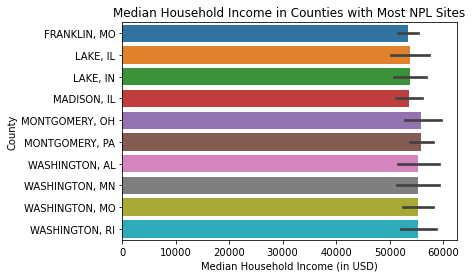

In [24]:
ax = sns.barplot(x="median household income", y="county", data=mhi_top_df)

# add title and axis labels (modify x-axis label)
ax.set_title('Median Household Income in Counties with Most NPL Sites')
ax.set_xlabel('Median Household Income (in USD)')
ax.set_ylabel('County')

In [25]:
bottom_10

['CROW WING, MN',
 'CENTRE, PA',
 'SANTA ROSA, FL',
 'RACINE, WI',
 'MAHONING, OH',
 'VOLUSIA, FL',
 'WHATCOM, WA',
 'CREEK, OK',
 'GUERNSEY, OH',
 'TUSCARAWAS, OH']

In [26]:
mhi_bottom_df = mhi_df[mhi_df['county'].isin(bottom_10)]

Text(0, 0.5, 'County')

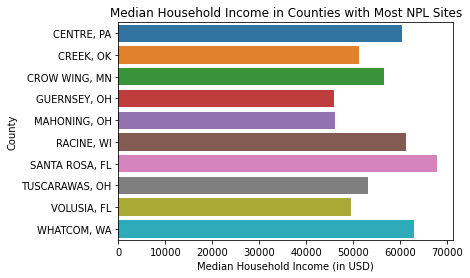

In [27]:
ax = sns.barplot(x="median household income", y="county", data=mhi_bottom_df)

# add title and axis labels (modify x-axis label)
ax.set_title('Median Household Income in Counties with Most NPL Sites')
ax.set_xlabel('Median Household Income (in USD)')
ax.set_ylabel('County')

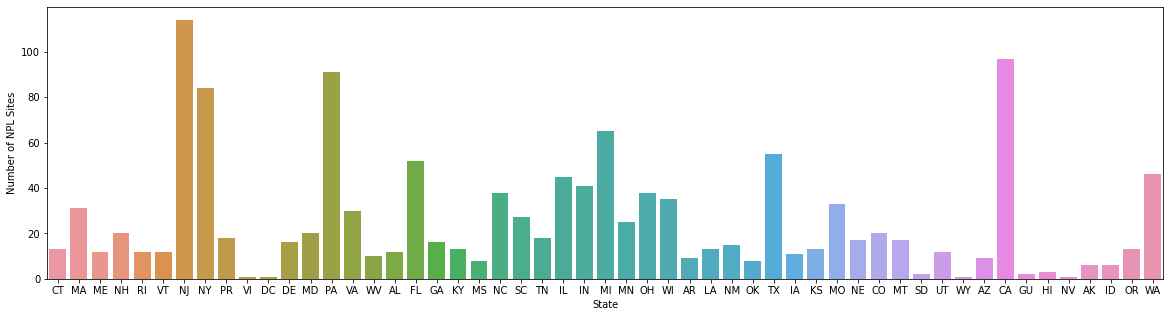

In [28]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='state', data=npl_df);
ax.set_xticklabels(ax.get_xticklabels())
ax.set(xlabel='State', ylabel='Number of NPL Sites')
plt.show()